In [206]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO, Predictive, NUTS, MCMC, config_enumerate
from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal
from pyro.optim import Adam, ClippedAdam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pyro.distributions import MultivariateNormal as MN

In [208]:
# Create artificial dataset
T = 40
k = 20
num = 500
N = (np.ones(T)*num).astype(int)
# Draw samples
samples = torch.zeros((1, T, num, 2))

for i in range(T):
    for j in range(num):
        ass = np.random.randint(0, 4)
            # Determine which cluster
        if ass == 0:
            samples[:, i, j, 0] = torch.randn(1)+5
            samples[:, i, j, 1] = torch.randn(1)-5
        elif ass == 1:
            samples[:, i, j, 0] = torch.randn(1)+5
            samples[:, i, j, 1] = torch.randn(1)+5
        elif ass == 2:
            samples[:, i, j, 0] = torch.randn(1)-5
            samples[:, i, j, 1] = torch.randn(1)+5
        elif ass == 3:
            samples[:, i, j, 0] = torch.randn(1)-5
            samples[:, i, j, 1] = torch.randn(1)-5
X = samples

lim = [[-8,8], [-8,8]]

# Allocate
U = torch.zeros((1, T, k, k))
for i in range(T-1):
    # Extract current lat/lon
    temp = X[:, i, :int(N[i]), :] 
    x = temp.numpy()[:,:,0][0]
    y = temp.numpy()[:,:,1][0]
    # Compute 2d histogram of current values in given grid
    u, r1, r2 = np.histogram2d(x=x, y=y, bins=[k,k], range=lim)
    # Normalise such that values sum to 1
    if u.sum() > 0:
        u /= u.sum()
    # Fill
    U[:, i+1, :, :] =  torch.from_numpy(u)

# First U (zeros) is discarded alongside first X

X_train = X[:, :T//2, :, :]
X_val   = X[:, (T//2):, :, :]
U_train = U[:, :T//2, :, :]
U_val   = U[:, (T//2):, :, :]
N_train = N[:T//2]
N_val   = N[T//2:]

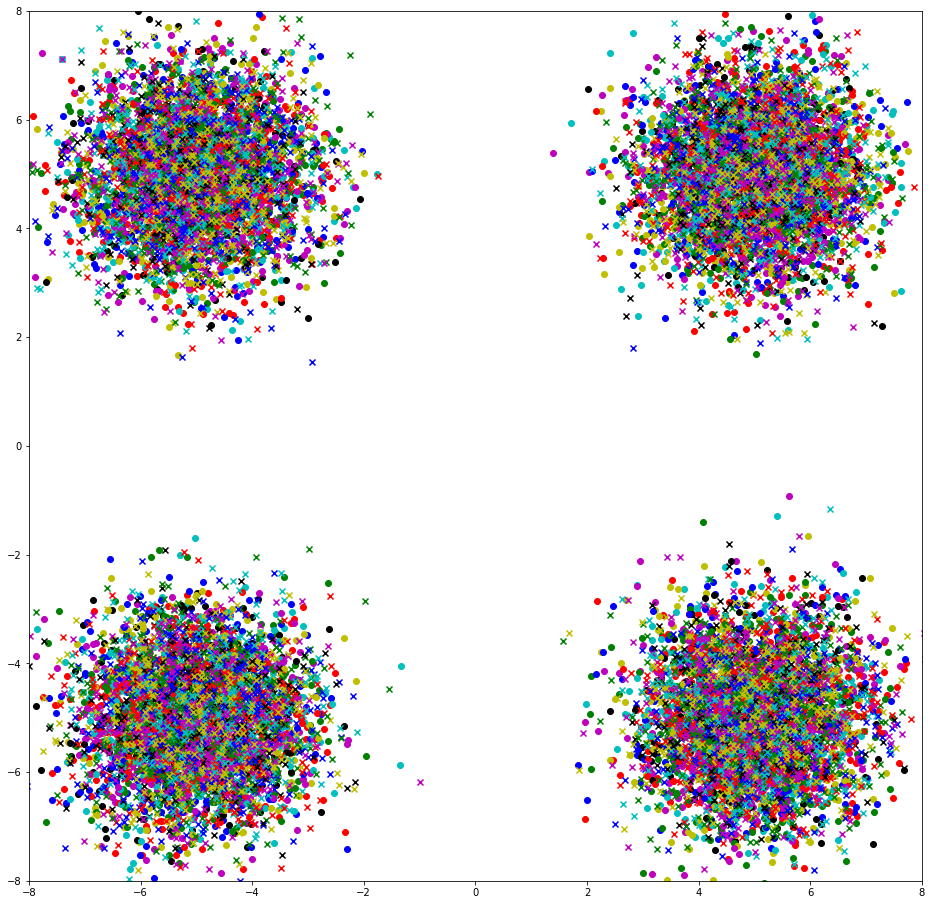

In [210]:
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'r', 'b', 'g', 'c', 'm', 'y', 'k', 'r', 'b', 'g', 'c', 'm', 'y', 'k', 'r', 'b', 'g', 'c', 'm', 'y', 'k', 'r', 'b', 'g', 'c', 'm', 'y', 'k', 'r', 'b', 'g', 'c', 'm', 'y', 'k']
plt.figure(figsize=(16,16))
#for t in range(T-1):
#    if t in even:
#        plt.scatter(x=X[:,t, :, 0].numpy(), y=X[:,t, :, 1].numpy(), color=colors[t])
#    else:
#        plt.scatter(x=X[:,t, :, 0].numpy(), y=X[:,t, :, 1].numpy(), color=colors[t], marker='x')
for t in range(X_train.size(1)):
    plt.scatter(x=X_train[:,t, :, 0].numpy(), y=X_train[:,t, :, 1].numpy(), color=colors[t])
for t in range(X_val.size(1)):
    plt.scatter(x=X_val[:,t, :, 0].numpy(), y=X_val[:,t, :, 1].numpy(), color=colors[t], marker='x')

plt.xlim(lim[0])
plt.ylim(lim[1])
plt.show()

In [211]:
# Class for extracting data
class RFNDataset(Dataset):
    """Spatio-temporal demand modelling dataset."""
    def __init__(self, X, U):
        self.X = X
        self.U = U

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        X_i, U_i = self.X[idx].float(), self.U[idx].float()
        return X_i, U_i

In [303]:
dataset  = RFNDataset(X_train, U_train)
dataloader= DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [304]:
# Recurrent Mixture Density network

class RMDN(nn.Module):
    """
    PyTorch class for Recurrent Mixture Density Network
    Inputs:
        input_dim:  dimension of input tensor U
        hidden_dim: number of hidden units to be used in various hidden layers
        output_dim: dimension of output, lat/lon
        K: number of mixture components
        
    Outputs:
        loc:    Tensor of mean values for Gaussians
        pi:     Mixture components
        Cov:    Covariance matrices
        hidden: Hidden states
    
    """
    def __init__(self, input_dim, hidden_dim, output_dim, K):
        super(RMDN, self).__init__()
        # Define parameters
        self.input_dim = input_dim
        self.hidden_dim= hidden_dim
        self.output_dim= output_dim
        self.K = K 
        self.tril_indices = torch.tril_indices(row=output_dim, col=output_dim, offset=-1)

        # Define LSTM
        self.lstm = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=1)
        # Fully connected layer 
        self.inp = nn.Linear(in_features=self.input_dim, out_features=self.hidden_dim)
        self.lstm_to_hidden     = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.hidden_to_hidden   = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        # Take output of fully connected layer and feed to layers for GMM components
        self.hidden_to_loc      = nn.Linear(in_features=self.hidden_dim, out_features=self.K*self.output_dim)
        self.hidden_to_sigma    = nn.Linear(in_features=self.hidden_dim, out_features=self.K*self.output_dim)
        self.hidden_to_off_diag = nn.Linear(in_features=self.hidden_dim, out_features=self.K)
        self.hidden_to_mix      = nn.Linear(in_features=self.hidden_dim, out_features=self.K)
        
        # Functions
        self.relu = nn.ReLU()
        self.elu  = nn.ELU()
        self.softmax = nn.Softmax(dim=1)
        self.softplus = nn.Softplus()
        
        # Dropout
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        
    def forward(self, U, hidden):     
        # Feed through LSTM
        #y, hidden = self.lstm(U.view(-1, 1, self.input_dim), hidden)
        y = self.elu(self.inp(U.view(-1, 1, self.input_dim)))
        # Fully connected
        y     = self.dropout1(self.elu(self.lstm_to_hidden(y)))
        y     = self.dropout2(self.elu(self.hidden_to_hidden(y)))
        # Compute mean values
        loc   = self.hidden_to_loc(y).view(-1, self.K, self.output_dim)
        # Compute variances (must be positive)
        sigma = self.softplus(self.hidden_to_sigma(y)).view(-1, self.K, self.output_dim)
        # Compute covariances
        cov   = self.hidden_to_off_diag(y).view(-1, self.K, 1)
        # Compute mixture components (must sum to 1)
        pi    = self.softmax(self.hidden_to_mix(y).view(-1,self.K, 1))
        # Create full covariance matrix
        cov_tril = torch.zeros((U.shape[0], self.K, self.output_dim, self.output_dim))
        for i in range(self.K):
            cov_tril[:, i, self.tril_indices[0], self.tril_indices[1]] = cov[:, i, :]
            cov_tril[:, i] += torch.diag_embed(sigma[:, i, :])
        
        return (loc, pi, cov_tril), hidden
    
    def init_hidden(self):
        # Initialise hidden states
        return (torch.zeros(1, 1, self.hidden_dim), torch.zeros(1, 1, self.hidden_dim))
    
    def get_loglikelihood(self, U, X, mask, U_init=None):
        # Feed U_init through network to obtain beginning hidden states
        hidden = self.init_hidden()
        if U_init is not None:
            for i in range(U_init.size(1)):
                _, hidden = self.forward(U=U_init[:, i, :, :], hidden=hidden)
        
        # Compute loglikelihood
        logprob = 0
        T_max = U.size(1)
        with torch.no_grad():
            for t in range(0, T_max):
                # Extract components for current GMM
                (loc, pi, cov), hidden = self.forward(U=U[:, t, :, :], hidden=hidden)
                # Compute loglikelihood for all datapoints for current time interval
                for tt in range(mask[t]):
                    current_prob = 0
                    for i in range(self.K):
                        current_prob += pi.squeeze()[i] * torch.exp(MN(loc=loc.squeeze()[i], scale_tril=cov[:, i, :, :].squeeze()).log_prob(X[:, t, tt, :]))
                    logprob += torch.log(current_prob)
        return logprob
        
# Pyro version      
class PyroRMDN(nn.Module):
    """
    Generative model for the above RMDN.
    The class is used for training and sampling.
    """
    
    def __init__(self, input_dim, hidden_dim, output_dim, K, grid):
        super(PyroRMDN, self).__init__()
        # Initialise recurrent mixture density network
        self.RMDN = RMDN(input_dim, hidden_dim, output_dim, K)
        self.K = K
        self.output_dim = output_dim
        self.grid = grid        
        
    @config_enumerate   
    def model(self, X=None, U=None, mask=None, hidden=None, batch_size=1):
        # Number of sequences
        N = len(U)
        # Number of time steps
        T_max = U.size(1)
        # Batch size
        b = min(N, batch_size)
        # Dimension check
        assert U.shape == (N, T_max, self.grid, self.grid)       
        # Initialise sample tensor
        x_samples = torch.zeros((b, T_max, max(mask), 2))
        # Register with Pyro
        pyro.module("RMDN",self)
        # Main plate
        with pyro.plate("data", N, dim=-2):
            # Iterate through each time interval
            for t in pyro.markov(range(0, T_max)):
                # Extract mixture components
                (loc, pi, cov), hidden = self.RMDN(U[:, t, :, :], hidden)              
                with pyro.plate('density_%d'%t, size=mask[t], dim=-1):
                    # Draw which component
                    assignment = pyro.sample(f'assignment_{t}', dist.Categorical(pi.view(-1, self.K)).to_event(1))
                    # Extract corresponding mean and covariance
                    _loc = loc[:, assignment, :].view(-1, 2)
                    _cov = cov[:, assignment, :, :].view(-1, 2, 2)
                    # Draw sample as multivariate normal
                    if X is None:
                        x_samples[:, t, :mask[t]] = pyro.sample('x_%d'%t, MN(loc=_loc, scale_tril=_cov),obs=None)
                    else:
                        x_samples[:, t, :mask[t]] = pyro.sample('x_%d'%t, MN(loc=_loc, scale_tril=_cov),obs=X[:, t, :mask[t], :])

        return x_samples, pi, loc, cov
    
    def guide(self, X=None, U=None, mask=None, hidden=None):
        pass
    
    def get_loglikelihood(self, U, X, mask, U_init):
        return self.RMDN.get_loglikelihood(U, X, mask, U_init)


In [305]:
pyronet = PyroRMDN(input_dim=k*k, hidden_dim=128, output_dim=2, K=10, grid=k)
optimizer = pyro.optim.ClippedAdam({"lr": 0.001, "clip_norm": 5.})
svi = SVI(pyronet.model, pyronet.guide, optimizer, TraceEnum_ELBO(num_particles=1, max_plate_nesting=1))

In [306]:
pyro.clear_param_store()
num_epochs = 10000
train_losses = []
val_losses = []
validation_ll =  []
hidden = pyronet.RMDN.init_hidden()
for i in range(num_epochs):
    for X_i, U_i in dataloader:
        # Set model to training
        pyronet.train()
        # Take step and update parameters
        loss = svi.step(X_i, U_i, N_train, hidden) / (N_train.sum())
        # Save current loss
        train_losses.append(loss)       
        if i%1000 == 999 or i == 0:
            (loc, pi, cov), hidden = pyronet.RMDN(U=U_val[:, 0, :, :], hidden=hidden)
            print(pi.detach().squeeze())
            print(f"Epoch: {i+1}, \tLoss: {loss:.3f}\n")
            
        

tensor([0.1025, 0.1005, 0.1137, 0.1064, 0.0920, 0.0943, 0.0964, 0.1006, 0.1016,
        0.0920])
Epoch: 1, 	Loss: 57.463

tensor([4.4678e-05, 9.8590e-04, 2.4409e-01, 6.5692e-05, 8.6374e-05, 7.4948e-01,
        7.2933e-04, 1.4086e-04, 2.7804e-03, 1.5964e-03])
Epoch: 1000, 	Loss: 6.816

tensor([4.6355e-07, 1.8504e-06, 9.9992e-01, 1.1445e-06, 3.3113e-07, 6.5197e-05,
        6.9795e-07, 3.3098e-06, 1.8214e-06, 4.0406e-07])
Epoch: 2000, 	Loss: 6.117

tensor([5.2185e-07, 3.9992e-07, 9.9995e-01, 9.1763e-07, 4.2744e-07, 3.5930e-05,
        2.8587e-07, 6.6123e-06, 8.1167e-07, 9.6610e-07])
Epoch: 3000, 	Loss: 6.115



KeyboardInterrupt: 

In [259]:
# Run model and obtain distributions

# Initialise hidden states and feed training data through network
#hidden = pyronet.RMDN.init_hidden()
#for i in range(U_train.size(1)):
#    _, hidden = pyronet.RMDN(U=U_train[:, i, :, :], hidden=hidden)

# Go through validaiton set and extract components
#for t in range(U_val.size(1)):
    # Extract components for current GMM
#    (loc, pi, cov), hidden = pyronet.RMDN(U=U_val[:, t, :, :], hidden=hidden)
# Create mixture distribution to draw sample
#mix_dist = dist.Categorical(pi.squeeze().detach())

#loc = loc.squeeze().detach()
#cov = cov.squeeze().detach()

#num_samples = 1000
#samples = torch.zeros((num_samples, 2))
# Sample from distribution
#for i in range(num_samples):
    # Determine distribution to sample from
#    assignment = pyro.sample('assignment', mix_dist)
    # Draw current sample
#    samples[i, :] = pyro.sample('sample', MN(loc=loc[assignment], scale_tril=cov[assignment]))
#samples = samples.numpy()

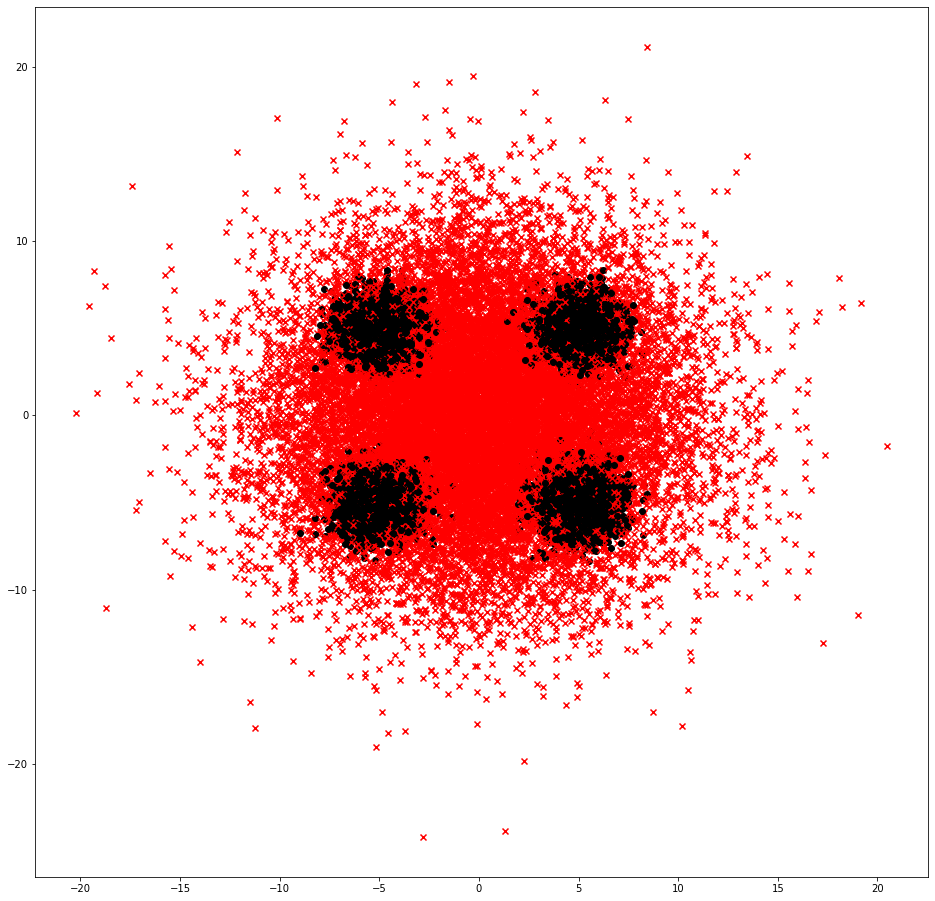

In [262]:
hidden = pyronet.RMDN.init_hidden()

# Prepare hidden states (currently irrevelant since network has no RNN component)
for t in range(U_train.size(1)):
    (loc, pi, cov_tril), hidden =  pyronet.RMDN(U=U_train[:,t, :, :], hidden=hidden)
    
# Run validation
plt.figure(figsize=(16,16))
for t in range(U_val.size(1)):
    # Extract components
    (loc, pi, cov_tril), hidden =  pyronet.RMDN(U=U_val[:,t, :, :], hidden=hidden)
    # Go through each component
    for i in range(pi.size(1)):
        # If pi > 0.01, draw 100 samples and plot them
        if pi.squeeze().detach()[i] > 0.01:
            test_distribution = torch.distributions.MultivariateNormal(loc=loc.squeeze().detach()[i], scale_tril=cov_tril.squeeze().detach()[i])
            new_samples = test_distribution.sample((100,))
            plt.scatter(x=new_samples[:, 0], y=new_samples[:, 1], marker='x', color='r')
    # Plot validation data
    plt.scatter(x=X_val[:,t, :, 0].numpy(), y=X_val[:,t, :, 1].numpy(), color='k')
    
plt.show()

In [266]:
loc

tensor([[[-0.0642,  0.9668],
         [-1.4895, -0.6730],
         [ 1.3594,  0.8248],
         [-0.2190, -0.5897],
         [-0.1361,  0.0212],
         [-0.4692, -0.1759],
         [-0.3156, -2.4510],
         [-0.1845, -0.0341],
         [-0.0782, -0.0132],
         [ 0.3815, -0.8428]]], grad_fn=<ViewBackward>)

In [224]:
U

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0040,  ..., 0.0020, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0060,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0040, 0.0060,  ..., 0.0080, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0020, 0.0120,  ..., 0.0161, 0.0020, 0.0020],
          [0.0000, 0.0040, 0.0060,  ..., 0.0080, 0.0000, 0.0000],
          [0.0000, 0.0020, 0.0020,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0020, 0.0020,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0060, 0.0020, 0.0020],
          [0.0020, 0.0040, 0.0060,  ..., 0

In [225]:
cov_tril

tensor([[[[ 5.5134,  0.0000],
          [ 0.0088,  5.5984]],

         [[ 5.9688,  0.0000],
          [ 0.3723,  5.2465]],

         [[ 6.6047,  0.0000],
          [ 0.3662,  4.8336]],

         [[ 5.0632,  0.0000],
          [ 0.3280,  5.0249]],

         [[ 5.4386,  0.0000],
          [ 0.0390,  5.4464]],

         [[ 6.2697,  0.0000],
          [-0.4387,  6.3761]],

         [[ 5.4921,  0.0000],
          [ 0.6845,  5.6488]],

         [[ 5.5204,  0.0000],
          [ 0.5371,  5.2807]],

         [[ 5.7503,  0.0000],
          [ 0.0337,  5.7701]],

         [[ 6.8781,  0.0000],
          [-0.3348,  6.0853]]]], grad_fn=<CopySlices>)

In [226]:
loc

tensor([[[ 0.2276,  0.8564],
         [-1.0474, -0.8326],
         [ 0.6786,  0.9350],
         [-0.0235, -0.1623],
         [-0.1221,  0.1038],
         [ 0.1177, -0.5874],
         [-0.0716, -1.8181],
         [-1.6101,  0.3337],
         [-0.0526,  0.0069],
         [ 0.0467, -0.1214]]], grad_fn=<ViewBackward>)

In [227]:
#for t in range(U_val.size(1)):
#    plt.imshow(np.flipud(U_val[0, t, :, :].numpy()), interpolation='bicubic',cmap='seismic', aspect='auto', extent=(lim[0][0], lim[0][1], lim[1][0], lim[1][1]))
#    plt.show()